#### Visual study of the ground-truth and predicted labels
This code plots and saves the images containing a certain label among its predicted labels. It saves the images to the res folder. Thought to be used for visual examination of the vsual relevance of the predictions (i.e. if the model is learning anything at all).

In [1]:
import sys
sys.path.append('..')
import json
import numpy as np
import pandas as pd
import tensorflow as tf
import help_functions as hf
from matplotlib import pyplot as plt
from tensorflow.keras.preprocessing.image import load_img

Using TensorFlow backend.


Plot images with their ground-truth labels, and predicted labels

In [2]:
i = 111
with open('../training_configurations.json', 'r') as fp:
    config = json.load(fp)[str(i)]

In [14]:
test, test_df = hf.get_flow(df_file='../' + config['data_folder'] + '/10k_samples_from_train.json.bz2',
                       batch_size=config['batch_size'],
                       nr_classes=config['nr_classes'],
                       image_dimension=config['image_dimension'])

Found 10000 validated image filenames belonging to 30 classes.


In [15]:
test_df.head()

id                                    title  \
2174015  26786342                    Normal Epiglottis.jpg   
931726   64054699         52267 2065rootlessconesclose.jpg   
2302880  57892868        Wonder Bar Atlantic City 1940.jpg   
1673563  17730399                     Brooklyn Works 2.JPG   
397065    5636103  Northlander at Englehart 2008 12 21.jpg   

                                                  url  \
2174015                    d/d6/Normal_Epiglottis.jpg   
931726          8/84/52267_2065rootlessconesclose.jpg   
2302880        8/8a/Wonder_Bar_Atlantic_City_1940.jpg   
1673563                     1/1b/Brooklyn_Works_2.JPG   
397065   2/25/Northlander_at_Englehart_2008_12_21.jpg   

                                                categories  \
2174015                                     [Human larynx]   
931726   [Volcanoes on Mars, Photos of Elysium quadrang...   
2302880  [Buildings in Atlantic City, New Jersey, Forme...   
1673563  [Brooklyn Works, Sheffield, 19th-century archi...   
397065   [Englehart station, Northlander (train), GMD G...   

                                           labels  can_be_opened  
2174015                        [Society, Culture]           True  
931726                     [Places, Nature, STEM]           True  
2302880                         [Places, Culture]           True  
1673563  [Places, Culture, Architecture, History]           True  
397065           [Technology & Engineering, STEM]           True

## Study 1: Plot images of each label

In [10]:
# Create model
model = hf.create_model(
                        # n_labels=len(test.class_indices), 
                        n_labels=len(test.class_indices) + 1, # 31 
                        image_dimension=config['image_dimension'], 
                        model_name=config['basemodel'], 
                        number_trainable_layers=config['number_trainable_layers'])
latest = tf.train.latest_checkpoint('../' + config['results_folder'])
model.load_weights(latest)

# Predict on test set
print('Predicting on test set:\n')
probs_test = model.predict(test, verbose=1)

THRESHOLD_MOVE = False
if not THRESHOLD_MOVE:
    y_pred = 1 * (probs_test > 0.5)
else:
    # Get optimal thresholds
    val_threshold, _ = hf.get_flow(df_file=config['data_folder'] + '/val_threshold_df.json.bz2',
                                nr_classes=config['nr_classes'],
                                image_dimension=config['image_dimension'])

    # Predict on validation set
    print('Predicting on validation set:\n')
    probs_val = model.predict(val_threshold, verbose=1)
    y_true_val = hf.get_y_true(shape=probs_val.shape, classes=val_threshold.classes)
    optim_thresholds = hf.get_optimal_threshold(y_true=y_true_val, 
                                                probs=probs_val, 
                                                thresholds=np.linspace(start=0, stop=1, num=21), 
                                                labels=list(val_threshold.class_indices.keys()), 
                                                N=7,
                                                image_path=config['results_folder'])
    y_pred = 1 * (probs_test > optim_thresholds)    

Predicting on test set:

20/20 [==============================] - 128s 6s/step


In [127]:
# Work around for using the '10k_samples_from_train' file, that does not have all of the 31 labels in it (missing 'Belief')

label_names = np.array(list(test.class_indices.keys()))
label_names_31 = [None] * 31
label_names_31[0:3] = label_names[0:3]
label_names_31[3] = 'Belief'
label_names_31[4:] = label_names[3:]
label_names = label_names_31
label_names

['Animals',
 'Architecture',
 'Art',
 'Belief',
 'Chemistry',
 'Culture',
 'Diagrams',
 'Events',
 'Food',
 'Fossils',
 'Geology',
 'History',
 'Landscapes',
 'Literature',
 'Logos & Symbols',
 'Maps & Flags',
 'Mathematics',
 'Medicine & Health',
 'Monuments & Memorials',
 'Music',
 'Nature',
 'People',
 'Places',
 'Plants',
 'Politics',
 'STEM',
 'Society',
 'Space',
 'Sports',
 'Technology & Engineering',
 'Transportation']

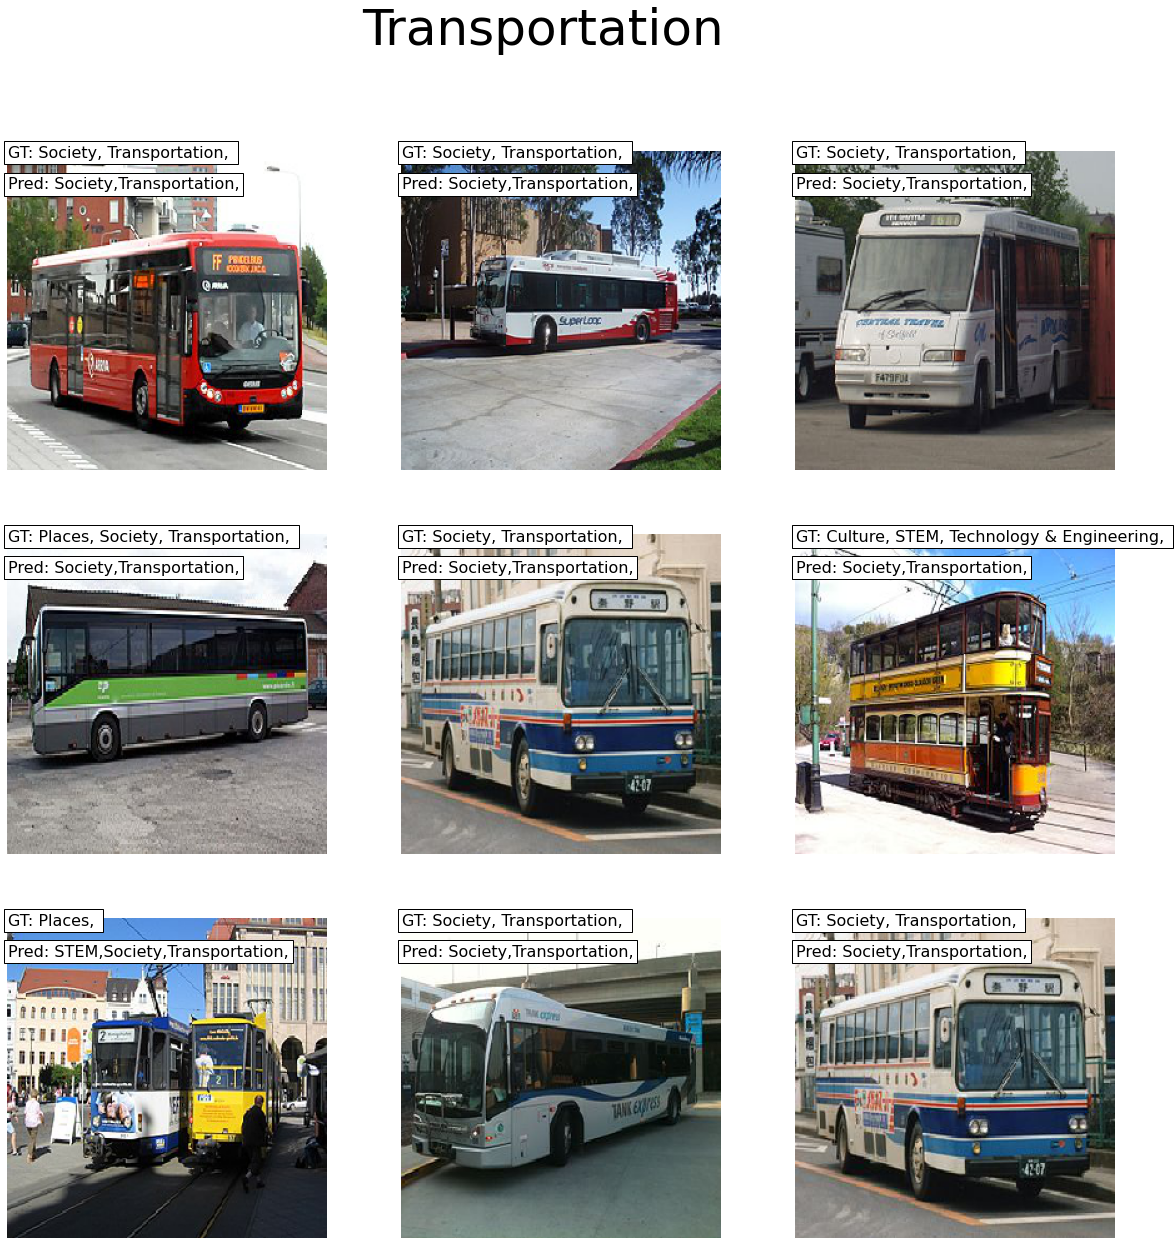

In [126]:
# def get_images_from_label(wished_label, img_path):
wished_label = 'Transportation'
wished_label_idx = label_names.index(wished_label)

columns = 3
rows = 3
fig, axs = plt.subplots(rows, columns, figsize=(20, 20))
indices_with_image = np.argwhere(y_pred[:, wished_label_idx] == 1).flatten()
random_indices = np.random.choice(indices_with_image, rows*columns, replace=True)

for i, idx, ax in zip(range(len(random_indices)), random_indices, axs.flatten()):
    path = '/scratch/WIT_Dataset/images/' + test_df.iloc[idx, :].url
    img = load_img(path, target_size=(256, 256))
    # plt.subplot(rows, columns, i + 1)
    ax.imshow(img)
    ax.axis('off')
    gt_str = 'GT: '
    gt_labels = test_df.iloc[idx, :].labels
    gt_labels.sort()
    gt_str += ''.join([label + ', ' for label in gt_labels])
    ax.text(x=0, y=5, s=gt_str, fontsize=16, bbox=dict(facecolor='white', edgecolor='black'))

    mask = y_pred[idx, :].astype(bool)
    predicted_labels = np.array(label_names)[mask]
    predicted_labels_str = 'Pred: '
    predicted_labels_str += ''.join([label + ',' for label in predicted_labels])
    ax.text(x=0, y=30, s=predicted_labels_str, fontsize=16, bbox=dict(facecolor='white', edgecolor='black'))

    plt.suptitle(wished_label, fontsize=50)

#         plt.savefig(img_path + '/' + wished_label + '.png')

# for label in label_names:
#     get_images_from_label(label, 'studies/images_pred_and_gt')

## Study 2: plot images of all labels

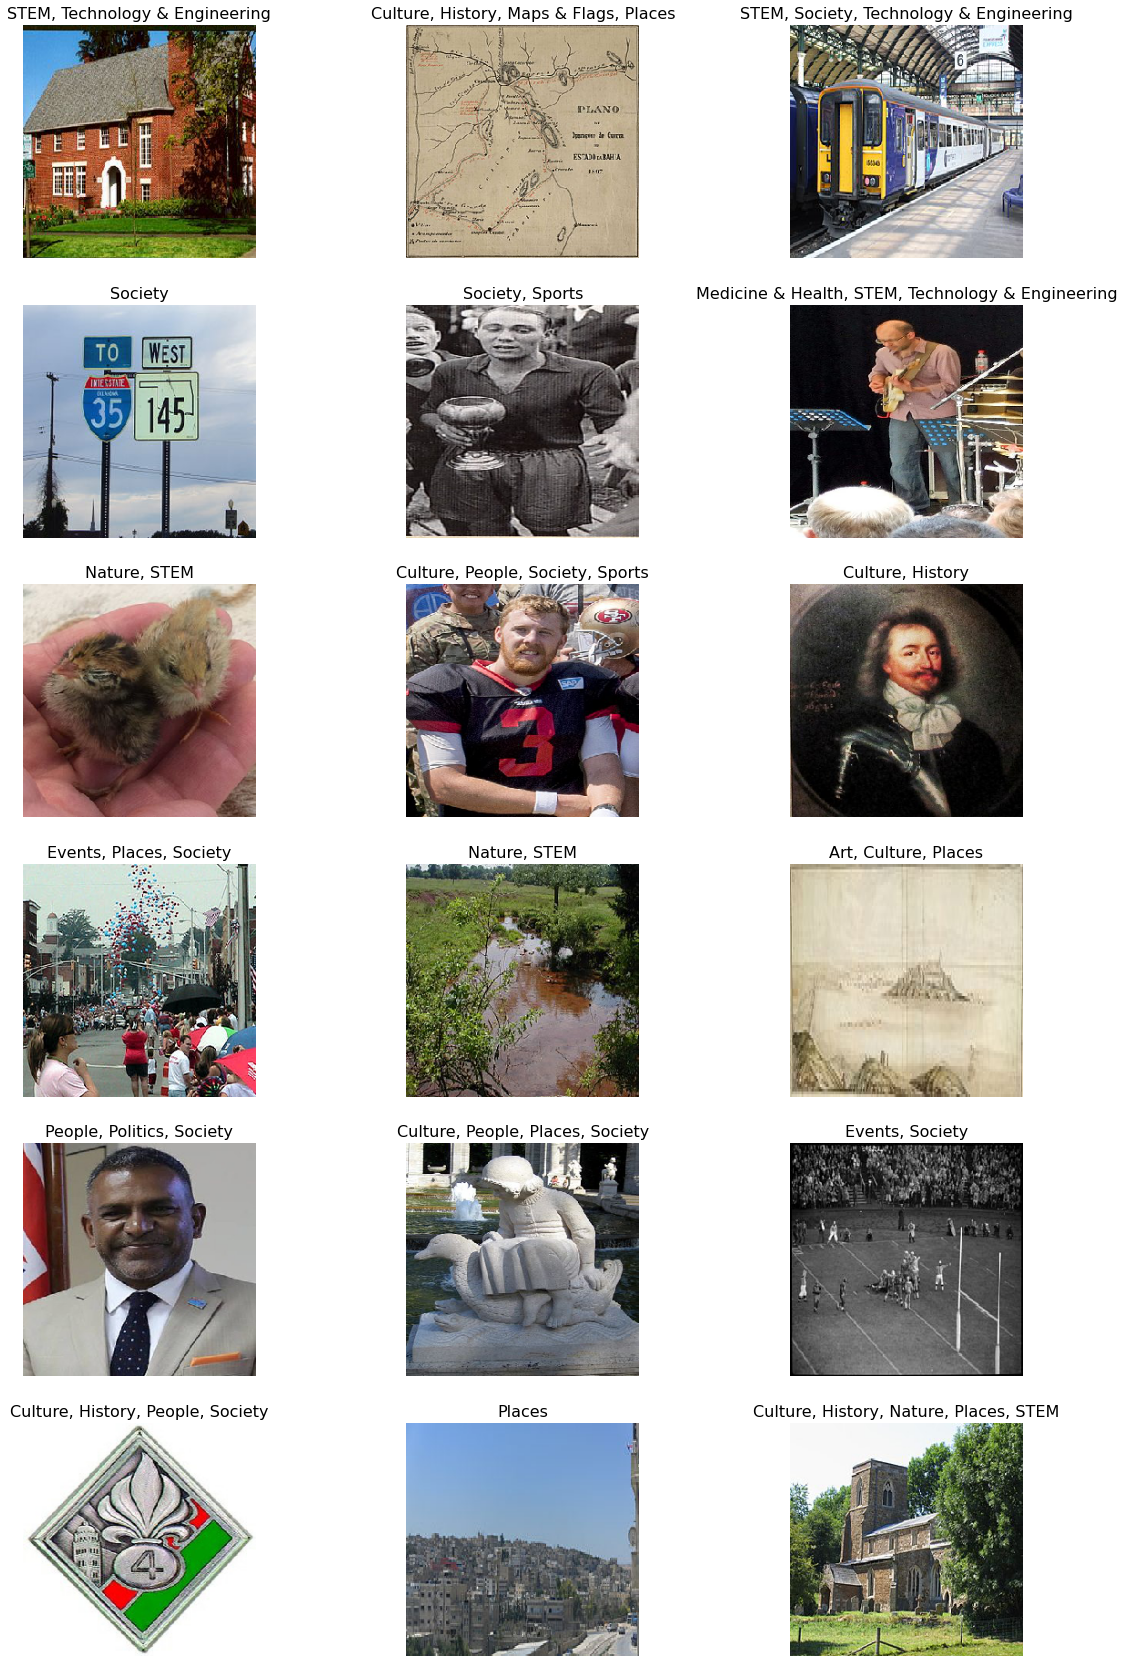

In [29]:
rows = 6
columns = 3
fig, axs = plt.subplots(rows, columns, figsize=(20, 30))
plt.subplots_adjust(wspace=0.1, hspace=0.2)
random_indices = np.random.randint(low=0, high=test_df.shape[0], size=rows*columns)

for i, idx, ax in zip(range(len(random_indices)), random_indices, axs.flatten()):
    path = '/scratch/WIT_Dataset/images/' + test_df.iloc[idx, :].url
    img = load_img(path, target_size=(256, 256))
    ax.imshow(img)
    ax.axis('off')
    gt_str = ''
    gt_labels = test_df.iloc[idx, :].labels
    gt_labels.sort()
    gt_str += ''.join([label + ', ' for label in gt_labels])
    ax.set_title(gt_str[0:-2], fontsize=16)